 The optimization package of Qiskit is mainly for QUBO, or general quadratic problems. However, as we are dealing with max-4-cut, we have terms upto order 4. It seems that we need to implement the QAOA algorithm on a circuit level, unless there are other packages unknown to us.

Please put reusable functions into python files and keep the minimum amount of code in this notebook. <br>
Thanks to Jakob and Franziska, now we have a sample data to work on with. I (Kevin) suggest that we follow a similar structure as 'https://qiskit.org/textbook/ch-applications/qaoa.html'. 
1. Use brute force to compute the costs for all combinations and find the optimal cost. This will be used for   scoring the performance of our QAOA implementation.
2. Construct the mixing hamiltonian and problem Hamiltonian gate by gate and draw out the circuit diagrams. (For this refer to Jezer's document)
3. Assemble the circuit and draw the circuit diagram
4. Run classical optimization. (I think Qiskit has a few built-in classical optimizers that we can use.)
5. Evaluate the results, and check the performance for different problem sizes and circuit depth.

In [60]:
from data_processing import *
from Max_k_cut_functions import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.compiler import transpile
from qiskit.circuit import Parameter

In [41]:
p = 3  # the depth of QAOA
l = 2  # the number of qubits for each node, k = 2^l where k is the number of subgraphs we'd like to cut, 
       # or to say, the k in 'max-k-cut'. l = 2 for a max-4-cut example 
n_imp = 2  # the number of important nodes, or to say the nodes with which the associated edges have larger weights
n_unimp = 3  # the number of less important nodes ... smaller weights
n = n_imp + n_unimp  # total number of nodes
nshots = 512  # the number of shots per iteration
init_params = [0.9,0.1,0.5,0.5,0.1,0.9]  # the initial parameters betas and gammas
method = 'Powell'  # the optimization algorithm to be used, supported by Scipy. 
                   # good candidates include 'Powell', 'COBYLA', 'Nelder-Mead', 'trust-constr'

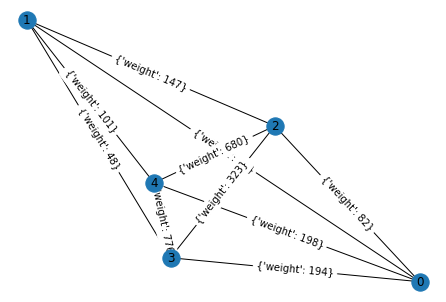

In [42]:
G = generate_data(n_unimp, n_imp)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

In [43]:
weights = get_weight_matrix(G)
print(weights)

[[  0  12  82 194 198]
 [ 12   0 147  48 101]
 [ 82 147   0 323 680]
 [194  48 323   0 776]
 [198 101 680 776   0]]


In [44]:
brut_force_k4_N5(G)  # Uses brute force to find the optimal solution, so that we have a reference to test our 
                     # algorithm

(2549, {'P0': [0, 1], 'P1': [2], 'P2': [3], 'P3': [4]})

In [45]:
mb = make_mixing_block(n,l,1)  # building the mixing block
mb.draw()

┌──────────┐
q_0: ┤ RX(2*β1) ├
     ├──────────┤
q_1: ┤ RX(2*β1) ├
     ├──────────┤
q_2: ┤ RX(2*β1) ├
     ├──────────┤
q_3: ┤ RX(2*β1) ├
     ├──────────┤
q_4: ┤ RX(2*β1) ├
     ├──────────┤
q_5: ┤ RX(2*β1) ├
     ├──────────┤
q_6: ┤ RX(2*β1) ├
     ├──────────┤
q_7: ┤ RX(2*β1) ├
     ├──────────┤
q_8: ┤ RX(2*β1) ├
     ├──────────┤
q_9: ┤ RX(2*β1) ├
     └──────────┘

In [46]:
cb = make_cost_block(n,l,weights,1)  # building the cost block 
cb.draw()

»
q_0: ──■─────────────────────■─────────■────────────────────────────────────■──»
       │                     │       ┌─┴─┐                                ┌─┴─┐»
q_1: ──┼────■────────────────┼────■──┤ X ├──■──────────────────────────■──┤ X ├»
     ┌─┴─┐  │  ┌──────────┐┌─┴─┐  │  └───┘┌─┴─┐                      ┌─┴─┐└───┘»
q_2: ┤ X ├──┼──┤ RZ(6*γ1) ├┤ X ├──┼───────┤ X ├──■────────────────■──┤ X ├─────»
     └───┘┌─┴─┐├──────────┤└───┘┌─┴─┐     └───┘┌─┴─┐┌──────────┐┌─┴─┐└───┘     »
q_3: ─────┤ X ├┤ RZ(6*γ1) ├─────┤ X ├──────────┤ X ├┤ RZ(6*γ1) ├┤ X ├──────────»
          └───┘└──────────┘     └───┘          └───┘└──────────┘└───┘          »
q_4: ──────────────────────────────────────────────────────────────────────────»
                                                                               »
q_5: ──────────────────────────────────────────────────────────────────────────»
                                                                               »
q_6: ──────────────────────────────────────────────────────────────────────────»
                                                                               »
q_7: ──────────────────────────────────────────────────────────────────────────»
                                                                               »
q_8: ──────────────────────────────────────────────────────────────────────────»
                                                                               »
q_9: ──────────────────────────────────────────────────────────────────────────»
                                                                               »
«                                                                            »
«q_0: ──■──────────────────────■─────────■───────────────────────────────────»
«       │                      │       ┌─┴─┐                                 »
«q_1: ──┼────■─────────────────┼────■──┤ X ├──■───────────────────────────■──»
«       │    │                 │    │  └───┘  │                           │  »
«q_2: ──┼────┼─────────────────┼────┼─────────┼───────────────────────────┼──»
«       │    │                 │    │         │                           │  »
«q_3: ──┼────┼─────────────────┼────┼─────────┼───────────────────────────┼──»
«     ┌─┴─┐  │  ┌───────────┐┌─┴─┐  │       ┌─┴─┐                       ┌─┴─┐»
«q_4: ┤ X ├──┼──┤ RZ(41*γ1) ├┤ X ├──┼───────┤ X ├──■─────────────────■──┤ X ├»
«     └───┘┌─┴─┐├───────────┤└───┘┌─┴─┐     └───┘┌─┴─┐┌───────────┐┌─┴─┐└───┘»
«q_5: ─────┤ X ├┤ RZ(41*γ1) ├─────┤ X ├──────────┤ X ├┤ RZ(41*γ1) ├┤ X ├─────»
«          └───┘└───────────┘     └───┘          └───┘└───────────┘└───┘     »
«q_6: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_7: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_8: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_9: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«                                                                             »
«q_0: ──■────────────────────■───────────────────────────────────■─────────■──»
«     ┌─┴─┐                  │                                   │       ┌─┴─┐»
«q_1: ┤ X ├──────────────────┼────■──────────────────────────────┼────■──┤ X ├»
«     └───┘                  │    │                              │    │  └───┘»
«q_2: ────────────■──────────┼────┼─────────────────────────■────┼────┼────■──»
«                 │          │    │                         │    │    │  ┌─┴─┐»
«q_3: ──■─────────┼──────────┼────┼────────────────────■────┼────┼────┼──┤ X ├»
«       │       ┌─┴─┐        │    │  ┌──────────────┐  │  ┌─┴─┐  │    │  └───┘»

In [47]:
ib = make_initial_block(n,l)
ib.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     ├───┤
q_4: ┤ H ├
     ├───┤
q_5: ┤ H ├
     ├───┤
q_6: ┤ H ├
     ├───┤
q_7: ┤ H ├
     ├───┤
q_8: ┤ H ├
     ├───┤
q_9: ┤ H ├
     └───┘

In [48]:
circ = make_full_circuit(n,l,weights,p)
circ.decompose().draw()

┌───┐┌──────────┐                                               »
    q_0: ┤ H ├┤ RX(2*β0) ├──■─────────────────────■─────────■────────────»
         ├───┤├──────────┤  │                     │       ┌─┴─┐          »
    q_1: ┤ H ├┤ RX(2*β0) ├──┼────■────────────────┼────■──┤ X ├──■───────»
         ├───┤├──────────┤┌─┴─┐  │  ┌──────────┐┌─┴─┐  │  └───┘┌─┴─┐     »
    q_2: ┤ H ├┤ RX(2*β0) ├┤ X ├──┼──┤ RZ(6*γ0) ├┤ X ├──┼───────┤ X ├──■──»
         ├───┤├──────────┤└───┘┌─┴─┐├──────────┤└───┘┌─┴─┐     └───┘┌─┴─┐»
    q_3: ┤ H ├┤ RX(2*β0) ├─────┤ X ├┤ RZ(6*γ0) ├─────┤ X ├──────────┤ X ├»
         ├───┤├──────────┤     └───┘└──────────┘     └───┘          └───┘»
    q_4: ┤ H ├┤ RX(2*β0) ├───────────────────────────────────────────────»
         ├───┤├──────────┤                                               »
    q_5: ┤ H ├┤ RX(2*β0) ├───────────────────────────────────────────────»
         ├───┤├──────────┤                                               »
    q_6: ┤ H ├┤ RX(2*β0) ├───────────────────────────────────────────────»
         ├───┤├──────────┤                                               »
    q_7: ┤ H ├┤ RX(2*β0) ├───────────────────────────────────────────────»
         ├───┤├──────────┤                                               »
    q_8: ┤ H ├┤ RX(2*β0) ├───────────────────────────────────────────────»
         ├───┤├──────────┤                                               »
    q_9: ┤ H ├┤ RX(2*β0) ├───────────────────────────────────────────────»
         └───┘└──────────┘                                               »
meas: 10/════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                          »
«    q_0: ────────────────────────■────■──────────────────────■─────────■──»
«                               ┌─┴─┐  │                      │       ┌─┴─┐»
«    q_1: ───────────────────■──┤ X ├──┼────■─────────────────┼────■──┤ X ├»
«                          ┌─┴─┐└───┘  │    │                 │    │  └───┘»
«    q_2: ──────────────■──┤ X ├───────┼────┼─────────────────┼────┼───────»
«         ┌──────────┐┌─┴─┐└───┘       │    │                 │    │       »
«    q_3: ┤ RZ(6*γ0) ├┤ X ├────────────┼────┼─────────────────┼────┼───────»
«         └──────────┘└───┘          ┌─┴─┐  │  ┌───────────┐┌─┴─┐  │       »
«    q_4: ───────────────────────────┤ X ├──┼──┤ RZ(41*γ0) ├┤ X ├──┼───────»
«                                    └───┘┌─┴─┐├───────────┤└───┘┌─┴─┐     »
«    q_5: ────────────────────────────────┤ X ├┤ RZ(41*γ0) ├─────┤ X ├─────»
«                                         └───┘└───────────┘     └───┘     »
«    q_6: ─────────────────────────────────────────────────────────────────»
«                                                                          »
«    q_7: ─────────────────────────────────────────────────────────────────»
«                                                                          »
«    q_8: ─────────────────────────────────────────────────────────────────»
«                                                                          »
«    q_9: ─────────────────────────────────────────────────────────────────»
«                                                                          »
«meas: 10/═════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                               »
«    q_0: ───────────────────────────────────■──────────────────»
«                                          ┌─┴─┐                »
«    q_1: ──■───────────────────────────■──┤ X ├────────────────»
«           │                           │  └───┘                »
«    q_2: ──┼───────────────────────────┼──────────────■────────»
«           │                           │              │        »
«    q_3: ──┼───────────────────────────┼────■─────

In [49]:
counts, n_counts, transpiled_circ = run_circuit(circ, init_params, nshots=nshots)
transpiled_circ.draw()

global phase: -2.7168
         ┌──────────────┐                                                      »
    q_0: ┤ U2(0,4.9416) ├──■─────────────────────────────────■─────────■───────»
         ├──────────────┤  │                                 │       ┌─┴─┐     »
    q_1: ┤ U2(0,4.9416) ├──┼────■────────────────────────────┼────■──┤ X ├──■──»
         ├──────────────┤┌─┴─┐  │  ┌──────────────────────┐┌─┴─┐  │  └───┘┌─┴─┐»
    q_2: ┤ U2(0,4.9416) ├┤ X ├──┼──┤ RZ(3.00000000000000) ├┤ X ├──┼───────┤ X ├»
         ├──────────────┤└───┘┌─┴─┐├──────────────────────┤└───┘┌─┴─┐     └───┘»
    q_3: ┤ U2(0,4.9416) ├─────┤ X ├┤ RZ(3.00000000000000) ├─────┤ X ├──────────»
         ├──────────────┤     └───┘└──────────────────────┘     └───┘          »
    q_4: ┤ U2(0,4.9416) ├──────────────────────────────────────────────────────»
         ├──────────────┤                                                      »
    q_5: ┤ U2(0,4.9416) ├──────────────────────────────────────────────────────»
         ├──────────────┤                                                      »
    q_6: ┤ U2(0,4.9416) ├──────────────────────────────────────────────────────»
         ├──────────────┤                                                      »
    q_7: ┤ U2(0,4.9416) ├──────────────────────────────────────────────────────»
         ├──────────────┤                                                      »
    q_8: ┤ U2(0,4.9416) ├──────────────────────────────────────────────────────»
         ├──────────────┤                                                      »
    q_9: ┤ U2(0,4.9416) ├──────────────────────────────────────────────────────»
         └──────────────┘                                                      »
meas: 10/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                               »
«    q_0: ─────────────────────────────────────────■────■───────»
«                                                ┌─┴─┐  │       »
«    q_1: ────────────────────────────────────■──┤ X ├──┼────■──»
«                                           ┌─┴─┐└───┘  │    │  »
«    q_2: ──■────────────────────────────■──┤ X ├───────┼────┼──»
«         ┌─┴─┐┌──────────────────────┐┌─┴─┐└───┘       │    │  »
«    q_3: ┤ X ├┤ RZ(3.00000000000000) ├┤ X ├────────────┼────┼──»
«         └───┘└──────────────────────┘└───┘          ┌─┴─┐  │  »
«    q_4: ────────────────────────────────────────────┤ X ├──┼──»
«                                                     └───┘┌─┴─┐»
«    q_5: ─────────────────────────────────────────────────┤ X ├»
«                                                          └───┘»
«    q_6: ──────────────────────────────────────────────────────»
«                                                               »
«    q_7: ──────────────────────────────────────────────────────»
«                                                               »
«    q_8: ──────────────────────────────────────────────────────»
«                                                               »
«    q_9: ──────────────────────────────────────────────────────»
«                                                               »
«meas: 10/══════════════════════════════════════════════════════»
«                                                               »
«                                                          »
«    q_0: ──────────────────────────■─────────■────────────»
«                                   │       ┌─┴─┐          »
«    q_1: ──────────────────────────┼────■──┤ X ├──■───────»
«                                   │    │  └───┘  │       »
«    q_2: ──────────────────────────┼────┼─────────┼───────»
«                                   │    │         │       »
«    q_3: ──────────────────────────┼────┼─────────┼───────»
«         ┌──────────────────────┐┌─┴─┐  │       ┌─┴─┐     »
«    q_4: ┤ RZ(20.5000000000000) ├┤ X ├──┼──────

In [50]:
average_cost = compute_cost(counts, l, weights, n_counts = n_counts)
average_cost

1935.205078125

In [51]:
func_to_optimize = circuit_optimize_wrapper(circ, l, weights, nshots=512, simulator='qasm_simulator')

In [90]:
res = minimize(func_to_optimize, init_params, method='Powell')
res

   direc: array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])
     fun: -2088.8671875
 message: 'Optimization terminated successfully.'
    nfev: 332
     nit: 3
  status: 0
 success: True
       x: array([-0.17249228, -0.15052536,  0.41907867,  2.49495174,  0.10413171,
        1.58440106])

In [70]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where ``x`` is an 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see her